# 一様最強力不偏検定の実装

* 黒木玄
* 2021-01-24

$P(x|\theta)$ は二項分布またはFisherの非心超幾何分布などの指数型離散分布族の確率函数であるとする:

$$
P(x|\theta) = c(\theta) h(x) e^{f(\theta)x}.
$$

ここで, $f(\theta)$ は $\theta$ の狭義単調増加函数であるとする. 例えば, 二項分布の場合には

$$
P(x|\theta) = \binom{n}{x} \theta^x (1 - \theta)^{n-x}
$$

なので

$$
f(\theta) = \log\frac{\theta}{1 - \theta}, \quad
c(\theta) = (1 - \theta)^n, \quad
h(x) = \binom{n}{x}
$$

このとき, $1 = \sum_x P(x|\theta)$ の両辺を $\theta$ で偏微分すると,

$$
\frac{P_\theta(x|\theta)}{P(x|\theta)} =
\frac{\partial}{\partial\theta}\log P(x|\theta) =
\frac{c'(\theta)}{c(\theta)} + f'(\theta)x
$$

より, $X \sim P(\cdot|\theta)$ のとき,

$$
0 =
\sum_x \left(\frac{c'(\theta)}{c(\theta)} + f'(\theta)x\right)P(x|\theta) =
\frac{c'(\theta)}{c(\theta)} + f'(\theta)E[X|\theta].
$$

ゆえに,

$$
P_\theta(x|\theta) = f'(\theta)(x - E[X|\theta]) P(x|\theta).
$$

帰無仮説 $\theta = \theta_0$, 対立仮説 $\theta \ne \theta_0$ の一様最強力不偏検定の検定函数(データ $x$ に対して帰無仮説 $\theta = \theta_0$ の棄却確率を返す函数)は以下の形で与えられることが知られている:

$$
\phi(x|\theta_0) =
\begin{cases}
1 & (x < a\; \text{or}\; b < x) \\
r_a & (x = a) \\
r_b & (x = b) \\
0 & (a < x < b) \\
\end{cases}
$$

ここで $a < b$ と $0\le r_a, r_b\le 1$ は次の条件で特徴付けられる:

$$
E[\phi(X|\theta_0)|\theta_0] = \alpha, \quad
\left.\frac{\partial}{\partial\theta}\right|_{\theta=\theta_0} E[\phi(X|\theta_0)|\theta] = 0.
$$

これらの等式は以下のように書き下される:

$$
\begin{aligned}
&
P(a|\theta_0)r_a + P(b|\theta_0)r_b + \sum_{x < a\; \text{or}\; b < x} P(x|\theta_0) = \alpha,
\\ &
\left.\frac{\partial}{\partial\theta}\right|_{\theta=\theta_0}
\left(P(a|\theta)r_a + P(b|\theta)r_b + \sum_{x < a\; \text{or}\; b < x} P(x|\theta)\right) = 0.
\end{aligned}
$$

後者の等式は, 上で示したように　$P_\theta(x|\theta) = f'(\theta)(x - E[X|\theta]) P(x|\theta)$ なので, 次と同値になることがわかる:

$$
a P(a|\theta_0) r_a + b P(b|\theta_0) r_b + \sum_{x < a\; \text{or}\; b < x} x P(x|\theta_0) =
E[X|\theta_0]E[\phi(X|\theta_0)|\theta_0] = \alpha E[X|\theta_0].
$$

したがって, $r_a, r_b$ は次の連立一次方程式の解になる:

$$
\begin{aligned}
&
P(a|\theta_0)r_a + P(b|\theta_0)r_b =
\alpha - \sum_{x < a\; \text{or}\; b < x} P(x|\theta_0) =: y_1,
\\ &
a P(a|\theta_0) r_a + b P(b|\theta_0) r_b =
\alpha E[X|\theta_0] - \sum_{x < a\; \text{or}\; b < x} x P(x|\theta_0) =: y_2.
\end{aligned}
$$

すなわち, 

$$
r_a = \frac{P(b|\theta_0)(b y_1 - y_2)}{(b - a)P(a|\theta_0)P(b|\theta_0)}, \quad
r_b = \frac{P(a|\theta_0)(y_2 - a y_1)}{(b - a)P(a|\theta_0)P(b|\theta_0)}.
$$

これらが $0$ 以上 $1$ 以下になる $a < b$ を探せばよい.

以下のコードはこれをそのまま素直に実装したものになっている.

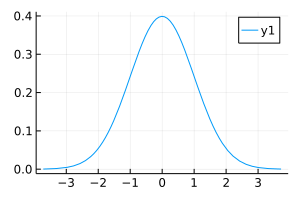

In [1]:
ENV["LINES"] = 200
ENV["COLUMNS"] = 200

using Distributions
using Memoization
using RCall
using StatsPlots
plot(Normal(); size=(300, 200))

In [2]:
x ⪅ y = x < y || x ≈ y
x ⪆ y = x > y || x ≈ y

@memoize function pval_exact(dist, k)
    pk = pdf(dist, k)
    P = sum(pdf(dist, j) for j in support(dist) if pdf(dist, j) ⪅ pk; init = 0.0)
    min(1, P)
end

@memoize pval_eqtailed(dist, k) = min(1, 2cdf(dist, k), 2ccdf(dist, k-1))

@memoize function pval_normal(dist, k)
    μ, σ = mean(dist), std(dist)
    2ccdf(Normal(), abs(k - μ)/σ)
end

pval_normal (generic function with 1 method)

In [3]:
function solve_umpu(dist, α = 0.05)
    s = support(dist)
    pmf(x) = pdf(dist, x)
    sol = Vector{Float64}[]
    r = Vector{Float64}(undef, length(s))
    for i in 1:length(s), j in length(s):-1:i+1
        a, b = s[i], s[j]
        P0 = cdf(dist, a - 1) + ccdf(dist, b)
        P0 > α && continue
        M0 = sum(s[k]*pmf(s[k]) for k in 1:i-1; init=0.0) + sum(s[k]*pmf(s[k]) for k in j+1:length(s); init=0.0)
        y1 = α - P0
        y2 = mean(dist)*α - M0
        d = (b - a)*pmf(a)*pmf(b)
        ri = pmf(b)*(b*y1 - y2)/d
        rj = pmf(a)*(y2 - a*y1)/d
        !(0 ⪅ ri ⪅ 1 && 0 ⪅ rj ⪅ 1) && continue 
        r .= 0
        r[1:i-1] .= 1
        r[j+1:end] .= 1
        r[i] = ri
        r[j] = rj
        push!(sol, copy(r))
    end
    sol
end

solve_umpu (generic function with 2 methods)

In [4]:
n = 10
theta = 0.1
dist = Binomial(n, theta)
alpha = 0.05
sol = solve_umpu(dist, alpha)

1-element Vector{Vector{Float64}}:
 [0.10883333104598232, 0.0, 0.0, 0.0, 0.9334214047502987, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [5]:
R"library(ump)"
@rput n theta alpha
r_R = Float64[]
for k in 0:n
    @rput k
    R"rk = umpu.binom(k, n, theta, alpha)"
    @rget rk
    push!(r_R, rk)
end
[r_R]

┌ Warning: RCall.jl: Warning: package 'ump' was built under R version 4.1.1
└ @ RCall D:\.julia\packages\RCall\iMDW2\src\io.jl:160


1-element Vector{Vector{Float64}}:
 [0.10883333104598227, 0.0, 0.0, 0.0, 0.9334214047503008, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [6]:
[r_R - sol[1]]

1-element Vector{Vector{Float64}}:
 [-5.551115123125783e-17, 0.0, 0.0, 0.0, 2.1094237467877974e-15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [7]:
@memoize function umpu!(r, dist, α = 0.05)
    s = support(dist)
    pmf(x) = pdf(dist, x)
    r .= 0
    for i in eachindex(s), j in lastindex(s):-1:i+1
        a, b = s[i], s[j]
        P0 = cdf(dist, a - 1) + ccdf(dist, b)
        P0 > α && continue
        M0 = sum(s[k]*pmf(s[k]) for k in 1:i-1; init=0.0) + sum(s[k]*pmf(s[k]) for k in j+1:length(s); init=0.0)
        y1 = α - P0
        y2 = mean(dist)*α - M0
        d = (b - a)*pmf(a)*pmf(b)
        ri = pmf(b)*(b*y1 - y2)/d
        rj = pmf(a)*(y2 - a*y1)/d
        !(0 ⪅ ri ⪅ 1 && 0 ⪅ rj ⪅ 1) && continue 
        r[1:i-1] .= 1
        r[j+1:end] .= 1
        r[i] = ri
        r[j] = rj
        break
    end
    r
end

@memoize function umpu(dist, α = 0.05)
    r = umpu!(zeros(length(support(dist))), dist, α)
    s = support(dist)
    function phi(x)
        i = x - minimum(s) + 1
        1 ≤ i ≤ lastindex(s) && return r[i]
        1.0
    end
    phi
end

function verify_umpu(dist, α = 0.05)
    phi = umpu(dist, α)
    s = support(dist)
    phix = phi.(s)
    EphiX = sum(x -> phi(x)*pdf(dist, x), s)
    EXphiX = sum(x -> x*phi(x)*pdf(dist, x), s)
    
    println("0 ≤ ϕ(x) ≤ 1     is ", all(0 .≤ phix .≤ 1))
    println("E[ϕ(X)]  ≈ α     is ", EphiX ≈ α)
    println("E[Xϕ(X)] ≈ αE[X] is ", EXphiX ≈ α*mean(dist))
    println()
    println("ϕ(x)          = ", phix)
    println("ϕ_normal(x)   = ", float(pval_normal.(dist, support(dist)) .< α))
    println("ϕ_exact(x)    = ", float(pval_exact.(dist, support(dist)) .< α))
    println("ϕ_eqtailed(x) = ", float(pval_eqtailed.(dist, support(dist)) .< α))
    println()
    println("ϕ(x) - ϕ_normal(x)   = ", phix - (pval_normal.(dist, s) .< α))
    println("ϕ(x) - ϕ_exact(x)    = ", phix - (pval_exact.(dist, s) .< α))
    println("ϕ(x) - ϕ_eqtailed(x) = ", phix - (pval_eqtailed.(dist, s) .< α))
end

verify_umpu (generic function with 2 methods)

竹内彰通『現代数理統計学』問8.9

* https://twitter.com/arts_lib/status/1475435871134707714

In [8]:
dist = Binomial(4, 1/3)
α = 0.1
verify_umpu(dist, α)

0 ≤ ϕ(x) ≤ 1     is true
E[ϕ(X)]  ≈ α     is true
E[Xϕ(X)] ≈ αE[X] is true

ϕ(x)          = [0.3020833333333333, 0.0, 0.0, 0.2833333333333334, 1.0]
ϕ_normal(x)   = [0.0, 0.0, 0.0, 1.0, 1.0]
ϕ_exact(x)    = [0.0, 0.0, 0.0, 0.0, 1.0]
ϕ_eqtailed(x) = [0.0, 0.0, 0.0, 0.0, 1.0]

ϕ(x) - ϕ_normal(x)   = [0.3020833333333333, 0.0, 0.0, -0.7166666666666666, 0.0]
ϕ(x) - ϕ_exact(x)    = [0.3020833333333333, 0.0, 0.0, 0.2833333333333334, 0.0]
ϕ(x) - ϕ_eqtailed(x) = [0.3020833333333333, 0.0, 0.0, 0.2833333333333334, 0.0]


In [9]:
dist = Binomial(4, 0.2)
α = 0.1
verify_umpu(dist, α)

0 ≤ ϕ(x) ≤ 1     is true
E[ϕ(X)]  ≈ α     is true
E[Xϕ(X)] ≈ αE[X] is true

ϕ(x)          = [0.18033854166666674, 0.0, 0.0, 0.9583333333333329, 1.0]
ϕ_normal(x)   = [0.0, 0.0, 0.0, 1.0, 1.0]
ϕ_exact(x)    = [0.0, 0.0, 0.0, 1.0, 1.0]
ϕ_eqtailed(x) = [0.0, 0.0, 0.0, 1.0, 1.0]

ϕ(x) - ϕ_normal(x)   = [0.18033854166666674, 0.0, 0.0, -0.041666666666667074, 0.0]
ϕ(x) - ϕ_exact(x)    = [0.18033854166666674, 0.0, 0.0, -0.041666666666667074, 0.0]
ϕ(x) - ϕ_eqtailed(x) = [0.18033854166666674, 0.0, 0.0, -0.041666666666667074, 0.0]


In [10]:
dist = Binomial(4, 0.2)
α = 0.1
pdf.(dist, 0:4)

5-element Vector{Float64}:
 0.4095999999999999
 0.40959999999999996
 0.15360000000000001
 0.02560000000000002
 0.0016000000000000005

In [11]:
@show a = 0
@show b = 2
@show P_left = sum(pdf.(dist, 0:a-1))
@show P_right = sum(pdf.(dist, b+1:n))
@show P0 = P_left + P_right
@show M0 = sum(x * pdf(dist, x) for x in 3:4)
@show y1 = α - P0
@show y2 = mean(dist)*α - M0
@show d = (b - a)*pdf(dist, a)*pdf(dist, b)
@show r_a = pdf(dist, b)*(b*y1 - y2)/d
@show r_b = pdf(dist, a)*(y2 - a*y1)/d;

a = 0 = 0
b = 2 = 2
P_left = sum(pdf.(dist, 0:a - 1)) = 0.0
P_right = sum(pdf.(dist, b + 1:n)) = 0.02720000000000002
P0 = P_left + P_right = 0.02720000000000002
M0 = sum((x * pdf(dist, x) for x = 3:4)) = 0.08320000000000007
y1 = α - P0 = 0.07279999999999999
y2 = mean(dist) * α - M0 = -0.00320000000000005
d = (b - a) * pdf(dist, a) * pdf(dist, b) = 0.12582912
r_a = (pdf(dist, b) * (b * y1 - y2)) / d = 0.18164062500000008
r_b = (pdf(dist, a) * (y2 - a * y1)) / d = -0.010416666666666827


In [12]:
@show a = 0
@show b = 3
@show P_left = sum(pdf.(dist, 0:a-1))
@show P_right = sum(pdf.(dist, b+1:n))
@show P0 = P_left + P_right
@show M0 = sum(x * pdf(dist, x) for x in 0:a-1; init=0.0) + sum(x * pdf(dist, x) for x in b+1:n; init=0.0)
@show y1 = α - P0
@show y2 = mean(dist)*α - M0
@show d = (b - a)*pdf(dist, a)*pdf(dist, b)
@show r_a = pdf(dist, b)*(b*y1 - y2)/d
@show r_b = pdf(dist, a)*(y2 - a*y1)/d;

a = 0 = 0
b = 3 = 3
P_left = sum(pdf.(dist, 0:a - 1)) = 0.0
P_right = sum(pdf.(dist, b + 1:n)) = 0.0016000000000000005
P0 = P_left + P_right = 0.0016000000000000005
M0 = sum((x * pdf(dist, x) for x = 0:a - 1); init = 0.0) + sum((x * pdf(dist, x) for x = b + 1:n); init = 0.0) = 0.006400000000000002
y1 = α - P0 = 0.0984
y2 = mean(dist) * α - M0 = 0.07360000000000001
d = (b - a) * pdf(dist, a) * pdf(dist, b) = 0.03145728000000001
r_a = (pdf(dist, b) * (b * y1 - y2)) / d = 0.18033854166666674
r_b = (pdf(dist, a) * (y2 - a * y1)) / d = 0.9583333333333329


In [13]:
dist = Binomial(10, 0.05)
α = 0.05
verify_umpu(dist, α)

0 ≤ ϕ(x) ≤ 1     is true
E[ϕ(X)]  ≈ α     is true
E[Xϕ(X)] ≈ αE[X] is true

ϕ(x)          = [0.07020057151207028, 0.0, 0.0, 0.6625095333354816, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ϕ_normal(x)   = [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ϕ_exact(x)    = [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ϕ_eqtailed(x) = [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

ϕ(x) - ϕ_normal(x)   = [0.07020057151207028, 0.0, -1.0, -0.33749046666451843, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ϕ(x) - ϕ_exact(x)    = [0.07020057151207028, 0.0, 0.0, -0.33749046666451843, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ϕ(x) - ϕ_eqtailed(x) = [0.07020057151207028, 0.0, 0.0, -0.33749046666451843, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [14]:
dist = Binomial(10, 0.1)
α = 0.05
verify_umpu(dist, α)

0 ≤ ϕ(x) ≤ 1     is true
E[ϕ(X)]  ≈ α     is true
E[Xϕ(X)] ≈ αE[X] is true

ϕ(x)          = [0.10883333104598232, 0.0, 0.0, 0.0, 0.9334214047502987, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ϕ_normal(x)   = [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ϕ_exact(x)    = [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ϕ_eqtailed(x) = [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

ϕ(x) - ϕ_normal(x)   = [0.10883333104598232, 0.0, 0.0, -1.0, -0.06657859524970133, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ϕ(x) - ϕ_exact(x)    = [0.10883333104598232, 0.0, 0.0, 0.0, -0.06657859524970133, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ϕ(x) - ϕ_eqtailed(x) = [0.10883333104598232, 0.0, 0.0, 0.0, -0.06657859524970133, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [15]:
dist = Binomial(10, 0.15)
α = 0.05
verify_umpu(dist, α)

0 ≤ ϕ(x) ≤ 1     is true
E[ϕ(X)]  ≈ α     is true
E[Xϕ(X)] ≈ αE[X] is true

ϕ(x)          = [0.1732080283011917, 0.0, 0.0, 0.0, 0.15028245967350284, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ϕ_normal(x)   = [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ϕ_exact(x)    = [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ϕ_eqtailed(x) = [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

ϕ(x) - ϕ_normal(x)   = [0.1732080283011917, 0.0, 0.0, 0.0, -0.8497175403264972, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ϕ(x) - ϕ_exact(x)    = [0.1732080283011917, 0.0, 0.0, 0.0, -0.8497175403264972, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ϕ(x) - ϕ_eqtailed(x) = [0.1732080283011917, 0.0, 0.0, 0.0, 0.15028245967350284, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [16]:
dist = Binomial(10, 0.2)
α = 0.05
verify_umpu(dist, α)

0 ≤ ϕ(x) ≤ 1     is true
E[ϕ(X)]  ≈ α     is true
E[Xϕ(X)] ≈ αE[X] is true

ϕ(x)          = [0.29302382469177257, 0.0, 0.0, 0.0, 0.0, 0.4604666573660706, 1.0, 1.0, 1.0, 1.0, 1.0]
ϕ_normal(x)   = [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ϕ_exact(x)    = [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ϕ_eqtailed(x) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]

ϕ(x) - ϕ_normal(x)   = [0.29302382469177257, 0.0, 0.0, 0.0, 0.0, -0.5395333426339294, 0.0, 0.0, 0.0, 0.0, 0.0]
ϕ(x) - ϕ_exact(x)    = [0.29302382469177257, 0.0, 0.0, 0.0, 0.0, -0.5395333426339294, 0.0, 0.0, 0.0, 0.0, 0.0]
ϕ(x) - ϕ_eqtailed(x) = [0.29302382469177257, 0.0, 0.0, 0.0, 0.0, 0.4604666573660706, 0.0, 0.0, 0.0, 0.0, 0.0]


In [17]:
dist = Binomial(10, 0.25)
α = 0.05
verify_umpu(dist, α)

0 ≤ ϕ(x) ≤ 1     is true
E[ϕ(X)]  ≈ α     is true
E[Xϕ(X)] ≈ αE[X] is true

ϕ(x)          = [0.5280428119019807, 0.0, 0.0, 0.0, 0.0, 0.00918414004833671, 1.0, 1.0, 1.0, 1.0, 1.0]
ϕ_normal(x)   = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ϕ_exact(x)    = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ϕ_eqtailed(x) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]

ϕ(x) - ϕ_normal(x)   = [0.5280428119019807, 0.0, 0.0, 0.0, 0.0, 0.00918414004833671, 0.0, 0.0, 0.0, 0.0, 0.0]
ϕ(x) - ϕ_exact(x)    = [0.5280428119019807, 0.0, 0.0, 0.0, 0.0, 0.00918414004833671, 0.0, 0.0, 0.0, 0.0, 0.0]
ϕ(x) - ϕ_eqtailed(x) = [0.5280428119019807, 0.0, 0.0, 0.0, 0.0, 0.00918414004833671, 0.0, 0.0, 0.0, 0.0, 0.0]


In [18]:
dist = Binomial(10, 0.3)
α = 0.05
verify_umpu(dist, α)

0 ≤ ϕ(x) ≤ 1     is true
E[ϕ(X)]  ≈ α     is true
E[Xϕ(X)] ≈ αE[X] is true

ϕ(x)          = [0.9577951588954973, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3360614190926662, 1.0, 1.0, 1.0, 1.0]
ϕ_normal(x)   = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ϕ_exact(x)    = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
ϕ_eqtailed(x) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]

ϕ(x) - ϕ_normal(x)   = [-0.04220484110450273, 0.0, 0.0, 0.0, 0.0, 0.0, -0.6639385809073338, 0.0, 0.0, 0.0, 0.0]
ϕ(x) - ϕ_exact(x)    = [-0.04220484110450273, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3360614190926662, 0.0, 0.0, 0.0, 0.0]
ϕ(x) - ϕ_eqtailed(x) = [0.9577951588954973, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3360614190926662, 0.0, 0.0, 0.0, 0.0]


In [19]:
dist = Binomial(10, 0.35)
α = 0.05
verify_umpu(dist, α)

0 ≤ ϕ(x) ≤ 1     is true
E[ϕ(X)]  ≈ α     is true
E[Xϕ(X)] ≈ αE[X] is true

ϕ(x)          = [1.0, 0.19806759582929057, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8186446822636986, 1.0, 1.0, 1.0]
ϕ_normal(x)   = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
ϕ_exact(x)    = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
ϕ_eqtailed(x) = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]

ϕ(x) - ϕ_normal(x)   = [0.0, 0.19806759582929057, 0.0, 0.0, 0.0, 0.0, 0.0, -0.18135531773630142, 0.0, 0.0, 0.0]
ϕ(x) - ϕ_exact(x)    = [0.0, 0.19806759582929057, 0.0, 0.0, 0.0, 0.0, 0.0, -0.18135531773630142, 0.0, 0.0, 0.0]
ϕ(x) - ϕ_eqtailed(x) = [0.0, 0.19806759582929057, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8186446822636986, 0.0, 0.0, 0.0]


In [20]:
dist = Binomial(10, 0.4)
α = 0.05
verify_umpu(dist, α)

0 ≤ ϕ(x) ≤ 1     is true
E[ϕ(X)]  ≈ α     is true
E[Xϕ(X)] ≈ αE[X] is true

ϕ(x)          = [1.0, 0.5033839480770204, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2676652319637339, 1.0, 1.0, 1.0]
ϕ_normal(x)   = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
ϕ_exact(x)    = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
ϕ_eqtailed(x) = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]

ϕ(x) - ϕ_normal(x)   = [0.0, 0.5033839480770204, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2676652319637339, 0.0, 0.0, 0.0]
ϕ(x) - ϕ_exact(x)    = [0.0, 0.5033839480770204, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2676652319637339, 0.0, 0.0, 0.0]
ϕ(x) - ϕ_eqtailed(x) = [0.0, 0.5033839480770204, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2676652319637339, 0.0, 0.0, 0.0]


In [21]:
dist = Binomial(10, 0.45)
α = 0.05
verify_umpu(dist, α)

0 ≤ ϕ(x) ≤ 1     is true
E[ϕ(X)]  ≈ α     is true
E[Xϕ(X)] ≈ αE[X] is true

ϕ(x)          = [1.0, 1.0, 0.0316942128753091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8659962945162255, 1.0, 1.0]
ϕ_normal(x)   = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
ϕ_exact(x)    = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
ϕ_eqtailed(x) = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]

ϕ(x) - ϕ_normal(x)   = [0.0, 0.0, 0.0316942128753091, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1340037054837745, 0.0, 0.0]
ϕ(x) - ϕ_exact(x)    = [0.0, 0.0, 0.0316942128753091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8659962945162255, 0.0, 0.0]
ϕ(x) - ϕ_eqtailed(x) = [0.0, 0.0, 0.0316942128753091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8659962945162255, 0.0, 0.0]


In [22]:
dist = Binomial(10, 0.5)
α = 0.05
verify_umpu(dist, α)

0 ≤ ϕ(x) ≤ 1     is true
E[ϕ(X)]  ≈ α     is true
E[Xϕ(X)] ≈ αE[X] is true

ϕ(x)          = [1.0, 1.0, 0.3244444444444446, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32444444444444415, 1.0, 1.0]
ϕ_normal(x)   = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
ϕ_exact(x)    = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
ϕ_eqtailed(x) = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]

ϕ(x) - ϕ_normal(x)   = [0.0, 0.0, 0.3244444444444446, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32444444444444415, 0.0, 0.0]
ϕ(x) - ϕ_exact(x)    = [0.0, 0.0, 0.3244444444444446, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32444444444444415, 0.0, 0.0]
ϕ(x) - ϕ_eqtailed(x) = [0.0, 0.0, 0.3244444444444446, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32444444444444415, 0.0, 0.0]


In [23]:
dist = Binomial(10, 0.55)
α = 0.05
verify_umpu(dist, α)

0 ≤ ϕ(x) ≤ 1     is true
E[ϕ(X)]  ≈ α     is true
E[Xϕ(X)] ≈ αE[X] is true

ϕ(x)          = [1.0, 1.0, 0.8659962945162274, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031694212875308825, 1.0, 1.0]
ϕ_normal(x)   = [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
ϕ_exact(x)    = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
ϕ_eqtailed(x) = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]

ϕ(x) - ϕ_normal(x)   = [0.0, 0.0, -0.1340037054837726, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031694212875308825, 0.0, 0.0]
ϕ(x) - ϕ_exact(x)    = [0.0, 0.0, 0.8659962945162274, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031694212875308825, 0.0, 0.0]
ϕ(x) - ϕ_eqtailed(x) = [0.0, 0.0, 0.8659962945162274, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031694212875308825, 0.0, 0.0]


In [24]:
dist = FisherNoncentralHypergeometric(11, 12, 15, 0.9)
α = 0.05
verify_umpu(dist, α)

0 ≤ ϕ(x) ≤ 1     is true
E[ϕ(X)]  ≈ α     is true
E[Xϕ(X)] ≈ αE[X] is true

ϕ(x)          = [1.0, 1.0, 0.1733264182850347, 0.0, 0.0, 0.0, 0.13042862393986684, 1.0, 1.0]
ϕ_normal(x)   = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
ϕ_exact(x)    = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
ϕ_eqtailed(x) = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]

ϕ(x) - ϕ_normal(x)   = [0.0, 0.0, 0.1733264182850347, 0.0, 0.0, 0.0, 0.13042862393986684, 0.0, 0.0]
ϕ(x) - ϕ_exact(x)    = [0.0, 0.0, 0.1733264182850347, 0.0, 0.0, 0.0, 0.13042862393986684, 0.0, 0.0]
ϕ(x) - ϕ_eqtailed(x) = [0.0, 0.0, 0.1733264182850347, 0.0, 0.0, 0.0, 0.13042862393986684, 0.0, 0.0]


In [25]:
prob_rejection(testfunc, α, n, p, q = p) = sum(testfunc(n, k, p, α) * pdf(Binomial(n, q), k) for k in 0:n)

function plot_bintest_powers(;
        α = 0.05,
        n = 10,
        test1 = (n, k, p, α) -> pval_exact(Binomial(n, p), k) < α,    title1 = "exact",
        test2 = (n, k, p, α) -> pval_eqtailed(Binomial(n, p), k) < α, title2 = "eqtailed",
        levels = [0.0:0.4α:2α; 0.2:0.2:1], kwargs...)
    p = q = 0.01:0.01:0.99
    xtick = ytick = 0:0.1:1
    xlim = ylim = (0, 1)
    
    A = prob_rejection.(test1, α, n, p', q)
    B = prob_rejection.(test2, α, n, p', q)
    AB = @. log2(B) - log2(A)
    
    P = contourf(p, q, A; clim=(0, 1), title=title1, levels, xtick, ytick, xlim, ylim, c=:CMRmap)
    Q = contourf(p, q, B; clim=(0, 1), title=title2, levels, xtick, ytick, xlim, ylim, c=:CMRmap)
    PQ = heatmap(p, q, AB; clim=(-1, 1), c=:bwr, title="power: $title1 b-w-r $title2", xtick, ytick, xlim, ylim)
    T1Err = plot(;xtick, ytick=0:0.2α:2α, xlim, ylim=(0, 2α), legend=:top)
    plot!(p, [A[i, i] for i in eachindex(p)]; label=title1)
    plot!(p, [B[i, i] for i in eachindex(p)]; label=title2)
    title!("probability of type-I errors")
    
    plot(P, Q, PQ, T1Err; size=(640, 640), layout=(2, 2), colorbar=false, contour_labels=true)
    plot!(; tickfontsize=5, titlefontsize=8, legendfontsize=7)
end

plot_bintest_powers (generic function with 1 method)

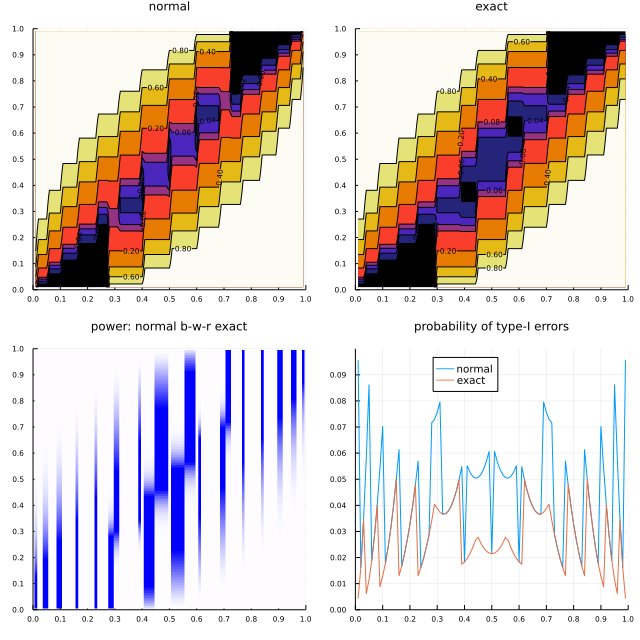

In [26]:
plot_bintest_powers(
    α = 0.05,
    n = 10,
    test1 = (n, k, p, α) -> pval_normal(Binomial(n, p), k) < α, title1 = "normal",
    test2 = (n, k, p, α) -> pval_exact(Binomial(n, p), k) < α,  title2 = "exact",
)

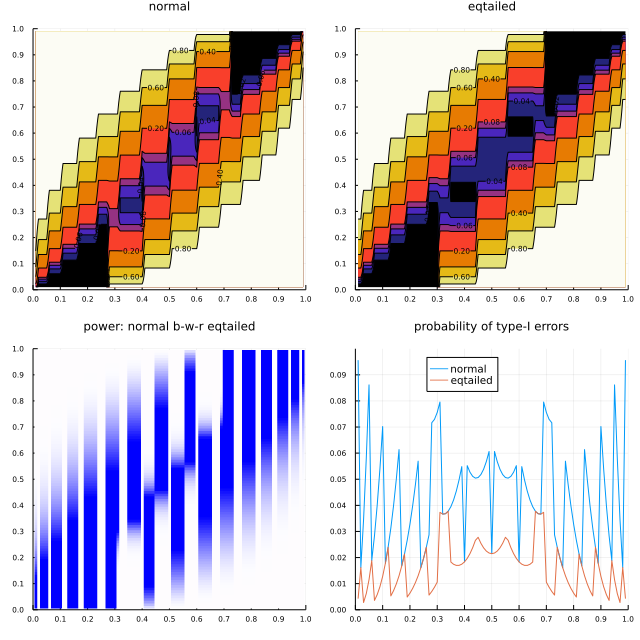

In [27]:
plot_bintest_powers(
    α = 0.05,
    n = 10,
    test1 = (n, k, p, α) -> pval_normal(Binomial(n, p), k) < α,   title1 = "normal",
    test2 = (n, k, p, α) -> pval_eqtailed(Binomial(n, p), k) < α, title2 = "eqtailed",
)

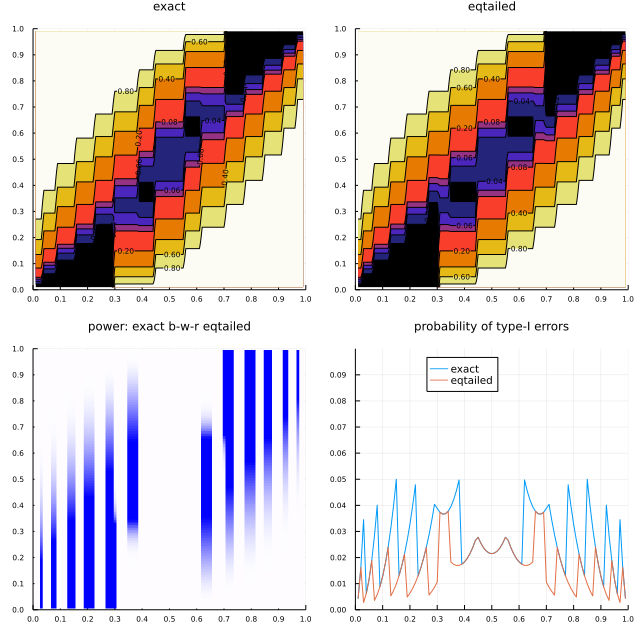

In [28]:
plot_bintest_powers(
    α = 0.05,
    n = 10,
    test1 = (n, k, p, α) -> pval_exact(Binomial(n, p), k) < α,    title1 = "exact", 
    test2 = (n, k, p, α) -> pval_eqtailed(Binomial(n, p), k) < α, title2 = "eqtailed",
)

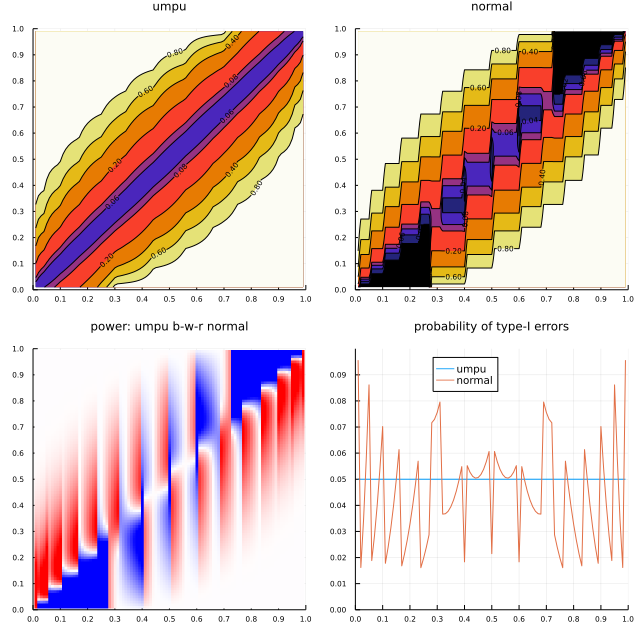

In [29]:
plot_bintest_powers(
    α = 0.05,
    n = 10,
    test1 = (n, k, p, α) -> umpu(Binomial(n, p), α)(k),         title1 = "umpu",
    test2 = (n, k, p, α) -> pval_normal(Binomial(n, p), k) < α, title2 = "normal",
)

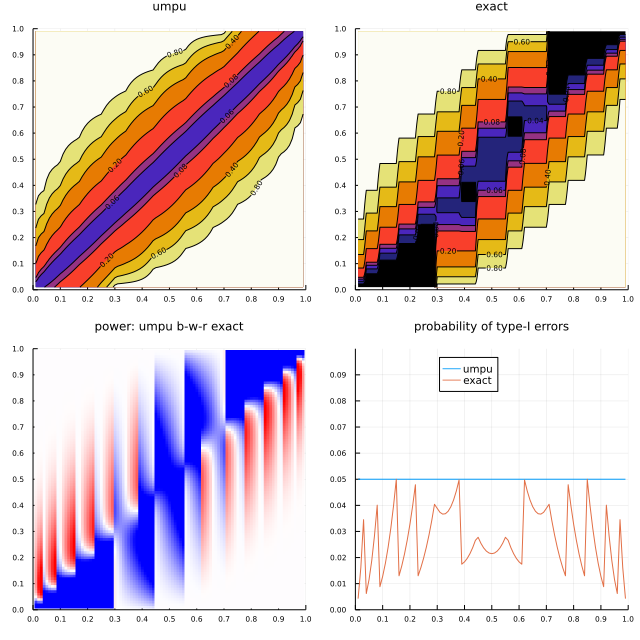

In [30]:
plot_bintest_powers(
    α = 0.05,
    n = 10,
    test1 = (n, k, p, α) -> umpu(Binomial(n, p), α)(k),         title1 = "umpu",
    test2 = (n, k, p, α) -> pval_exact(Binomial(n, p), k) < α,  title2 = "exact",
)

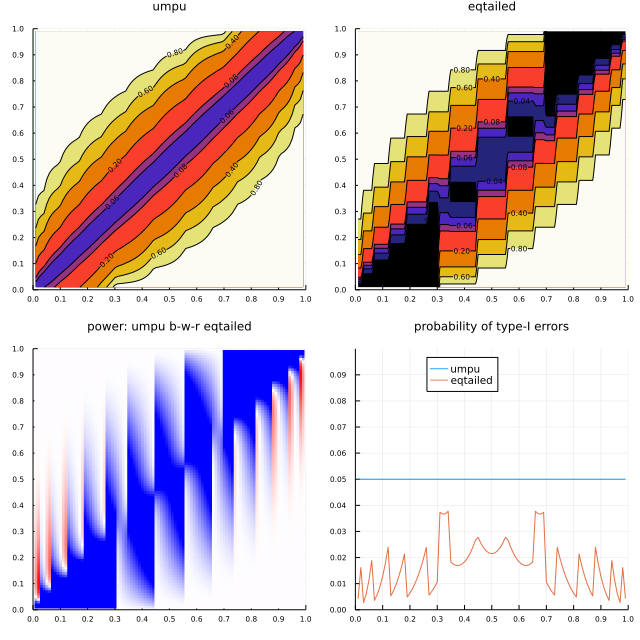

In [31]:
plot_bintest_powers(
    α = 0.05,
    n = 10,
    test1 = (n, k, p, α) -> umpu(Binomial(n, p), α)(k),           title1 = "umpu",
    test2 = (n, k, p, α) -> pval_eqtailed(Binomial(n, p), k) < α, title2 = "eqtailed",
)

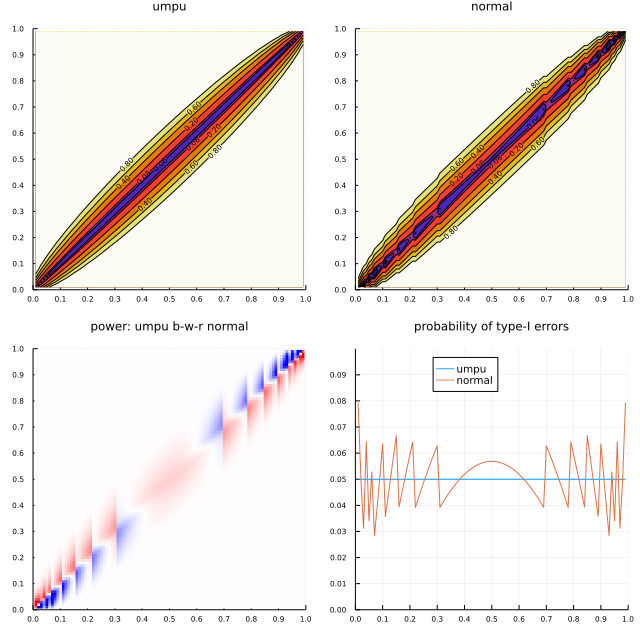

In [32]:
plot_bintest_powers(
    α = 0.05,
    n = 100,
    test1 = (n, k, p, α) -> umpu(Binomial(n, p), α)(k),         title1 = "umpu",
    test2 = (n, k, p, α) -> pval_normal(Binomial(n, p), k) < α, title2 = "normal",
)

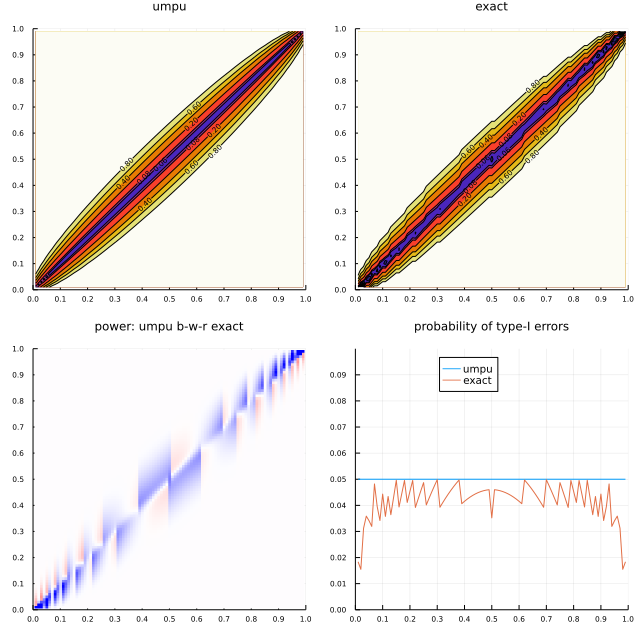

In [33]:
plot_bintest_powers(
    α = 0.05,
    n = 100,
    test1 = (n, k, p, α) -> umpu(Binomial(n, p), α)(k),         title1 = "umpu",
    test2 = (n, k, p, α) -> pval_exact(Binomial(n, p), k) < α,  title2 = "exact",
)

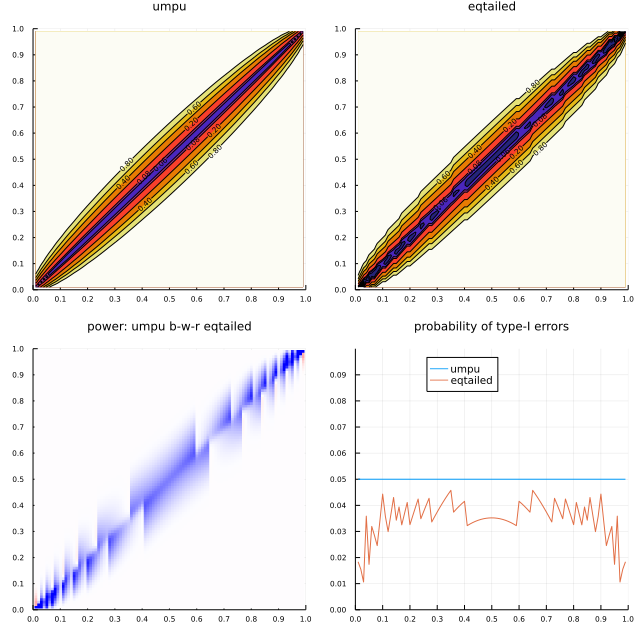

In [34]:
plot_bintest_powers(
    α = 0.05,
    n = 100,
    test1 = (n, k, p, α) -> umpu(Binomial(n, p), α)(k),           title1 = "umpu",
    test2 = (n, k, p, α) -> pval_eqtailed(Binomial(n, p), k) < α, title2 = "eqtailed",
)

In [35]:
function plot_bintest_phi(ϕ, n; kwargs...)
    x = 0:n
    θ = 0.001:0.001:0.999
    z = ϕ.(x', n, θ)
    heatmap(x, θ, z; ylim=(0, 1), kwargs...)
end

plot_bintest_phi (generic function with 1 method)

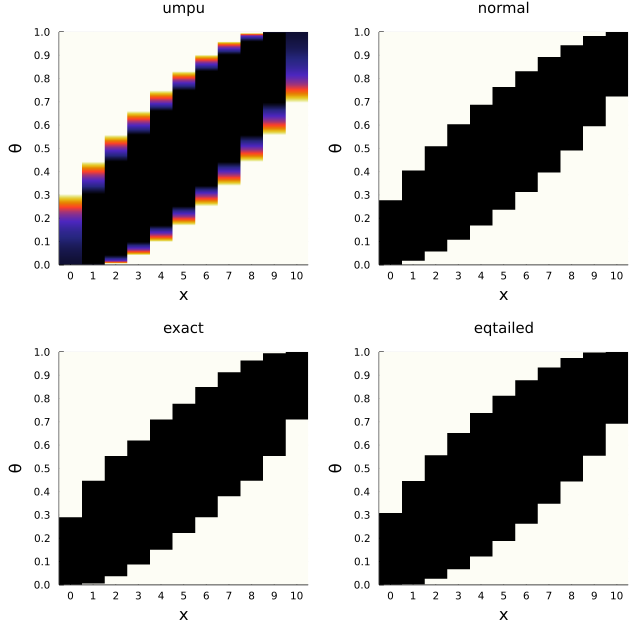

In [36]:
n = 10
α = 0.05

P1 = plot_bintest_phi((x, n, θ) -> umpu(Binomial(n, θ), α)(x), n; 
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="umpu")

P2 = plot_bintest_phi((x, n, θ) -> pval_normal(Binomial(n, θ), x) < α, n; 
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="normal")

P3 = plot_bintest_phi((x, n, θ) -> pval_exact(Binomial(n, θ), x) < α, n; 
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="exact")

P4 = plot_bintest_phi((x, n, θ) -> pval_eqtailed(Binomial(n, θ), x) < α, n; 
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="eqtailed")

plot(P1, P2, P3, P4; size=(640, 640))
plot!(; tickfontsize=7, titlefontsize=10)

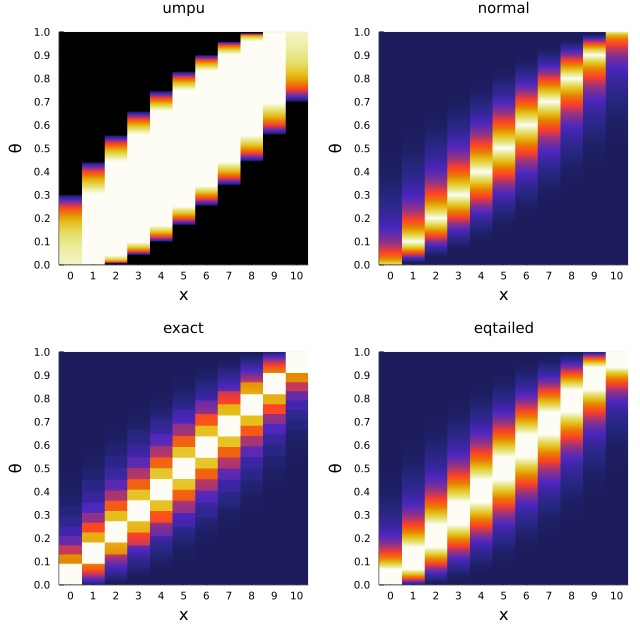

In [37]:
n = 10
α = 0.05

P1 = plot_bintest_phi((x, n, θ) -> 1 - umpu(Binomial(n, θ), α)(x), n; clim=(0, 1),
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="umpu")

P2 = plot_bintest_phi((x, n, θ) -> pval_normal(Binomial(n, θ), x), n; clim=(-0.1, 1),
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="normal")

P3 = plot_bintest_phi((x, n, θ) -> pval_exact(Binomial(n, θ), x), n; clim=(-0.1, 1),
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="exact")

P4 = plot_bintest_phi((x, n, θ) -> pval_eqtailed(Binomial(n, θ), x), n; clim=(-0.1, 1),
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="eqtailed")

plot(P1, P2, P3, P4; size=(640, 640))
plot!(; tickfontsize=7, titlefontsize=10)

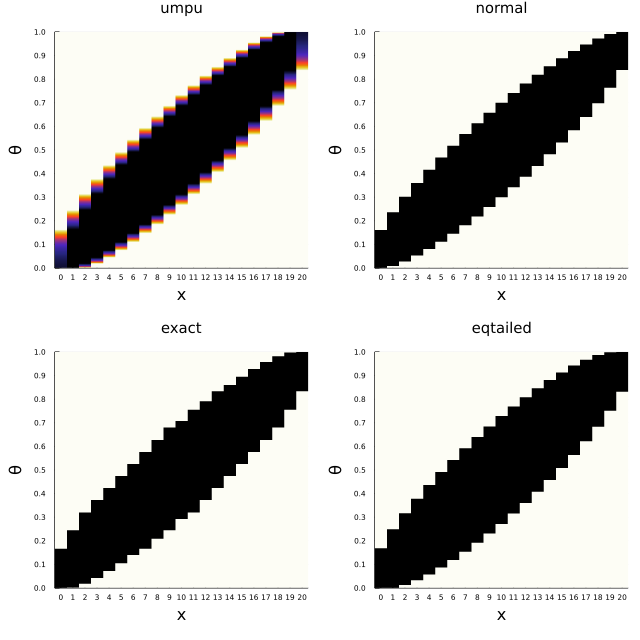

In [38]:
n = 20
α = 0.05

P1 = plot_bintest_phi((x, n, θ) -> umpu(Binomial(n, θ), α)(x), n; 
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="umpu")

P2 = plot_bintest_phi((x, n, θ) -> pval_normal(Binomial(n, θ), x) < α, n; 
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="normal")

P3 = plot_bintest_phi((x, n, θ) -> pval_exact(Binomial(n, θ), x) < α, n; 
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="exact")

P4 = plot_bintest_phi((x, n, θ) -> pval_eqtailed(Binomial(n, θ), x) < α, n; 
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="eqtailed")

plot(P1, P2, P3, P4; size=(640, 640))
plot!(; tickfontsize=5, titlefontsize=10)

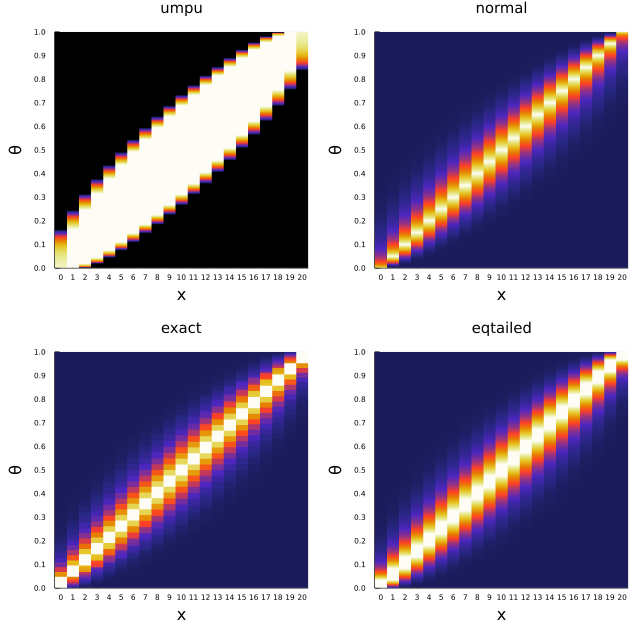

In [39]:
n = 20
α = 0.05

P1 = plot_bintest_phi((x, n, θ) -> 1 - umpu(Binomial(n, θ), α)(x), n; clim=(0, 1),
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="umpu")

P2 = plot_bintest_phi((x, n, θ) -> pval_normal(Binomial(n, θ), x), n; clim=(-0.1, 1),
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="normal")

P3 = plot_bintest_phi((x, n, θ) -> pval_exact(Binomial(n, θ), x), n; clim=(-0.1, 1),
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="exact")

P4 = plot_bintest_phi((x, n, θ) -> pval_eqtailed(Binomial(n, θ), x), n; clim=(-0.1, 1),
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="eqtailed")

plot(P1, P2, P3, P4; size=(640, 640))
plot!(; tickfontsize=5, titlefontsize=10)

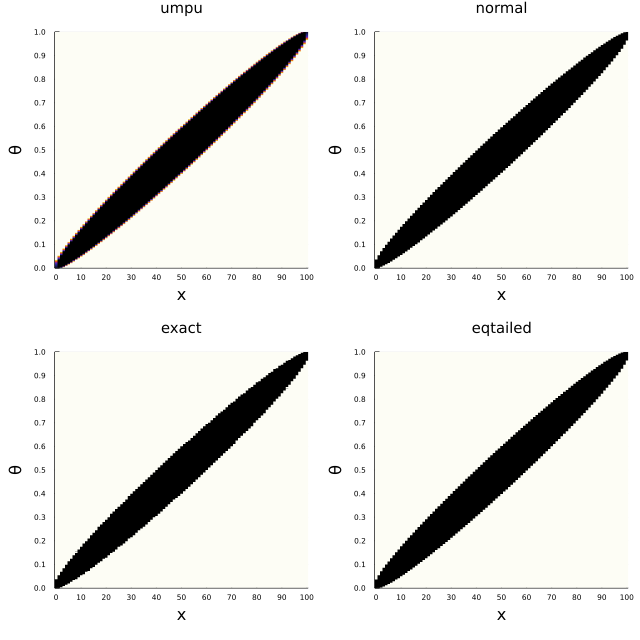

In [40]:
n = 100
α = 0.05

P1 = plot_bintest_phi((x, n, θ) -> umpu(Binomial(n, θ), α)(x), n; 
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:10:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="umpu")

P2 = plot_bintest_phi((x, n, θ) -> pval_normal(Binomial(n, θ), x) < α, n; 
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:10:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="normal")

P3 = plot_bintest_phi((x, n, θ) -> pval_exact(Binomial(n, θ), x) < α, n; 
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:10:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="exact")

P4 = plot_bintest_phi((x, n, θ) -> pval_eqtailed(Binomial(n, θ), x) < α, n; 
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:10:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="eqtailed")

plot(P1, P2, P3, P4; size=(640, 640))
plot!(; tickfontsize=5, titlefontsize=10)

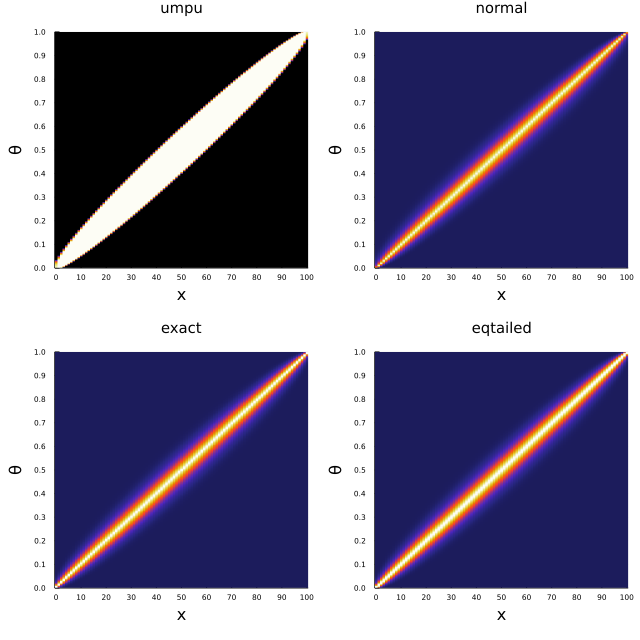

In [41]:
n = 100
α = 0.05

P1 = plot_bintest_phi((x, n, θ) -> 1 - umpu(Binomial(n, θ), α)(x), n; clim=(0, 1),
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:10:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="umpu")

P2 = plot_bintest_phi((x, n, θ) -> pval_normal(Binomial(n, θ), x), n; clim=(-0.1, 1),
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:10:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="normal")

P3 = plot_bintest_phi((x, n, θ) -> pval_exact(Binomial(n, θ), x), n; clim=(-0.1, 1),
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:10:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="exact")

P4 = plot_bintest_phi((x, n, θ) -> pval_eqtailed(Binomial(n, θ), x), n; clim=(-0.1, 1),
    size=(400, 400), colorbar=false, c=:CMRmap, xtick=0:10:n, ytick=0:0.1:1,
    xlabel="x", ylabel="θ", title="eqtailed")

plot(P1, P2, P3, P4; size=(640, 640))
plot!(; tickfontsize=5, titlefontsize=10)